In [1]:
# 1.
import sys
from importlib import reload

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

trackml_path = '/home/ec2-user/SageMaker/TrackML'
if trackml_path not in sys.path:
    sys.path.append(trackml_path)
    
from data_preparation import hit_order
reload(hit_order)

from helper_functions.file_utilities import file_url

In [2]:
coords = pd.concat(
    pd.read_csv(file_url("hits", event_id)).loc[:, ['x', 'y', 'z']]
    for event_id in range(21000, 21050)
)

coords["R_cylinder"] = np.sqrt(np.square(coords.x) + np.square(coords.y))
coords["R_sphere"] = np.sqrt(np.square(coords.x) + np.square(coords.y) + np.square(coords.z))
coords.head()

,x,y,z,R_cylinder,R_sphere
0,-86.7962,-14.73040,-1502.5,88.037293,1505.077013
1,-68.7035,-10.89900,-1502.5,69.562627,1504.109441
2,-56.1383,-9.50887,-1502.5,56.937925,1503.578457
3,-60.3114,-4.97231,-1502.5,60.516021,1503.718205
4,-89.4057,-8.81687,-1502.5,89.839392,1505.183499


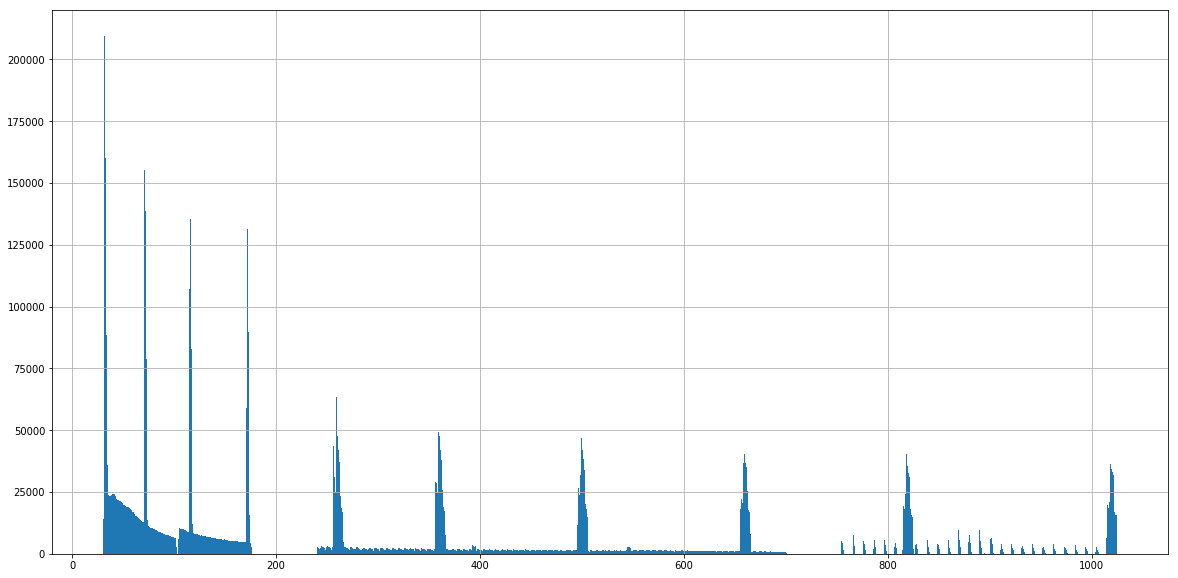

In [39]:
coords.R_cylinder.hist(bins=1000, figsize=(20, 10))
plt.show()

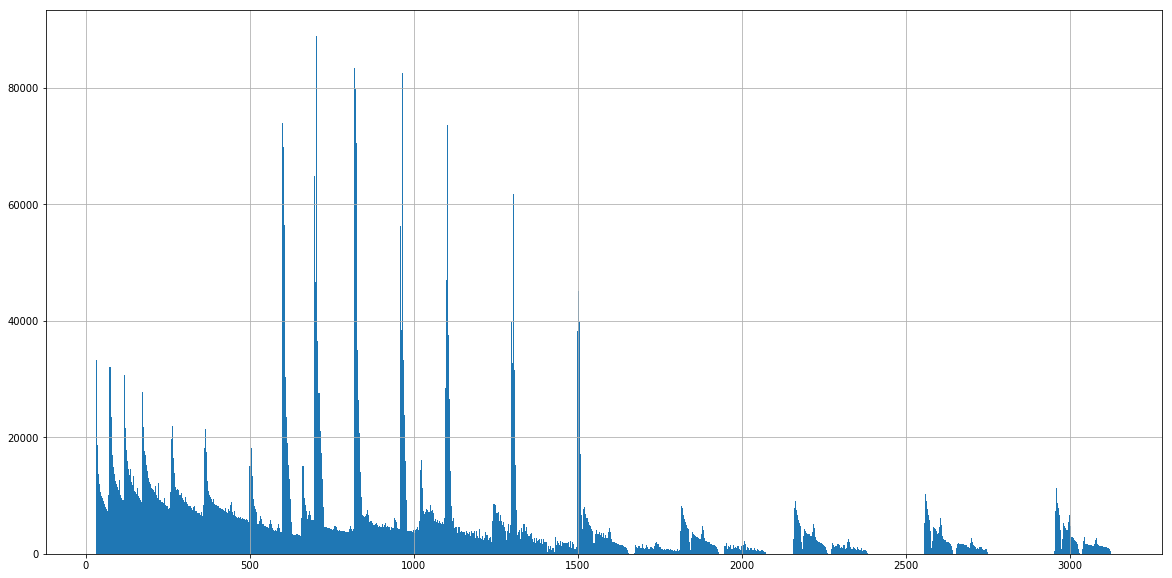

In [40]:
coords.R_sphere.hist(bins=1000, figsize=(20, 10))
plt.show()

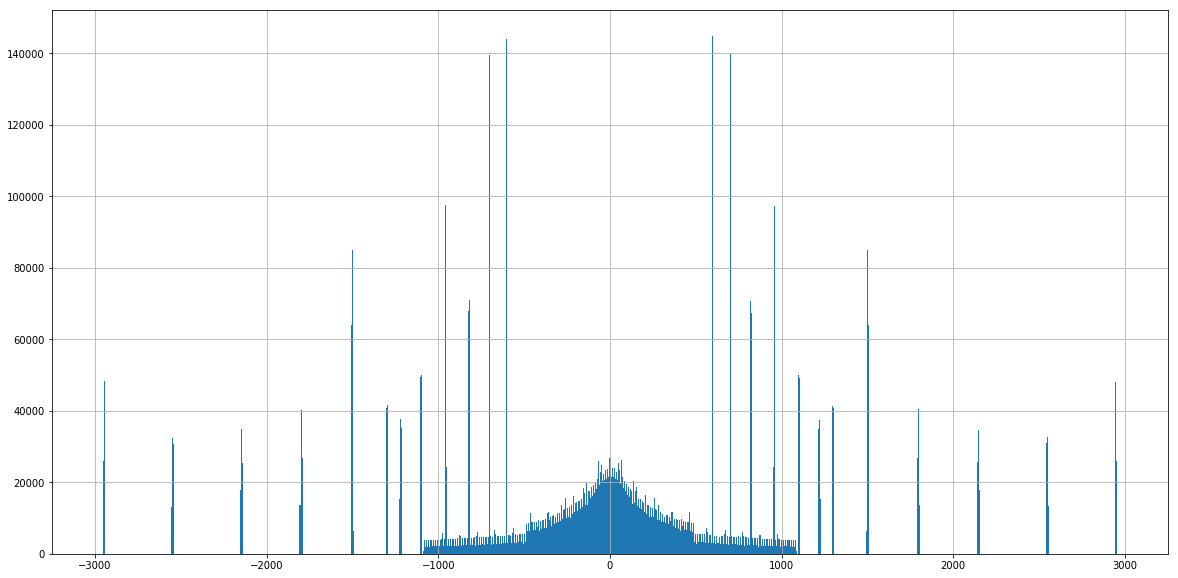

In [38]:
coords.z.hist(bins=1000, figsize=(20, 10))
plt.show()

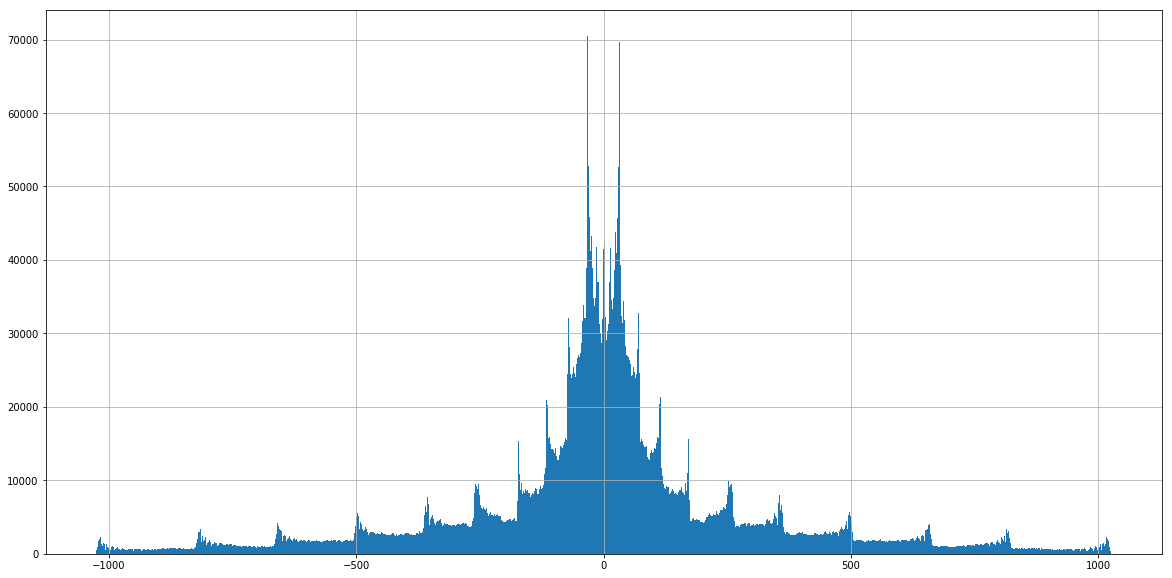

In [41]:
coords.x.hist(bins=1000, figsize=(20, 10))
plt.show()

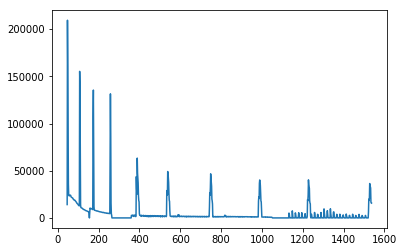

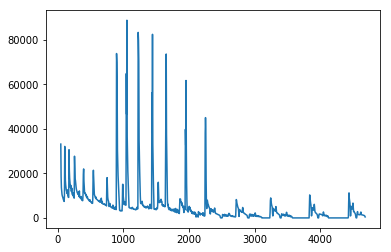

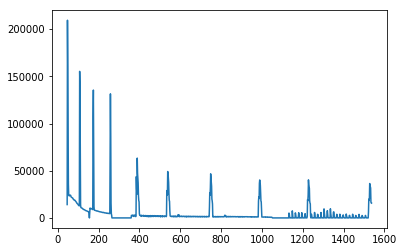

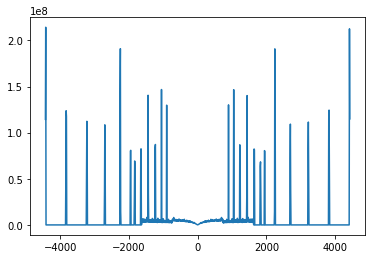

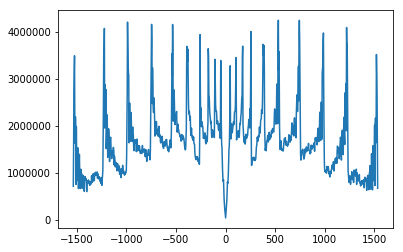

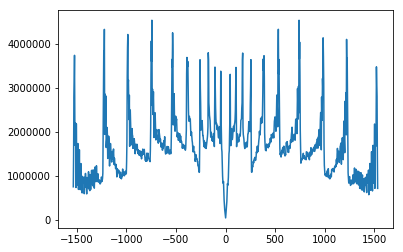

In [66]:
def get_centers(edges):
    centers = np.zeros(len(edges) - 1)
    for i in range(len(centers)):
        centers[i] = edges[i] + edges[i+1] / 2
        
    return centers
        
def plot_density(vals, bins, measure):
    count, edges = np.histogram(vals, bins=bins)
    centers = get_centers(edges)
    
    plt.plot(centers, count/measure(centers))
    plt.show()

plot_density(coords.R_cylinder, 1000, lambda x: 1)
plot_density(coords.R_sphere, 1000, lambda x: 1)
plot_density(coords.R_cylinder, 1000, lambda x: 1)
plot_density(coords.z, 1000, lambda x: np.abs(np.reciprocal(x)))
plot_density(coords.x, 1000, lambda x: np.abs(np.reciprocal(x)))
plot_density(coords.y, 1000, lambda x: np.abs(np.reciprocal(x)))

In [67]:
coords.z.min()

-2955.5

In [68]:
np.min(np.abs(coords.z))

9.53674e-07

In [2]:
detector = pd.read_csv('/home/ec2-user/SageMaker/efs/codalab_dataset/detectors.csv')
detector.head()

,volume_id,layer_id,module_id,cx,cy,cz,rot_xu,rot_xv,rot_xw,rot_yu,...,rot_yw,rot_zu,rot_zv,rot_zw,module_t,module_minhx,module_maxhx,module_hy,pitchX,pitchY
0,7,2,1,-65.7965,-5.17830,-1502.5,0.078459,-0.996917,0.0,-0.996917,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
1,7,2,2,-139.8510,-6.46568,-1502.0,0.046183,-0.998933,0.0,-0.998933,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
2,7,2,3,-138.6570,-19.34190,-1498.0,0.138156,-0.990410,0.0,-0.990410,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
3,7,2,4,-64.1764,-15.40740,-1498.0,0.233445,-0.972370,0.0,-0.972370,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625
4,7,2,5,-136.2810,-32.05310,-1502.0,0.228951,-0.973438,0.0,-0.973438,...,0.0,0,0,-1,0.15,8.4,8.4,36,0.05,0.05625


In [3]:
detector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18728 entries, 0 to 18727
Data columns (total 21 columns):
volume_id       18728 non-null int64
layer_id        18728 non-null int64
module_id       18728 non-null int64
cx              18728 non-null float64
cy              18728 non-null float64
cz              18728 non-null float64
rot_xu          18728 non-null float64
rot_xv          18728 non-null float64
rot_xw          18728 non-null float64
rot_yu          18728 non-null float64
rot_yv          18728 non-null float64
rot_yw          18728 non-null float64
rot_zu          18728 non-null int64
rot_zv          18728 non-null int64
rot_zw          18728 non-null int64
module_t        18728 non-null float64
module_minhx    18728 non-null float64
module_maxhx    18728 non-null float64
module_hy       18728 non-null int64
pitchX          18728 non-null float64
pitchY          18728 non-null float64
dtypes: float64(14), int64(7)
memory usage: 3.0 MB


In [124]:
hits = pd.concat(pd.read_csv(file_url("hits", event_id)).assign(event_id=event_id) for event_id in range(21000, 21010))

hits["R"] = np.sqrt(np.square(hits.x) + np.square(hits.y))
# hits["R_sphere"] = np.sqrt(np.square(hits.x) + np.square(hits.y) + np.square(hits.z))
hits["theta"] = np.arctan2(hits.x, hits.y)

# add bins for R, theta, z

p_hit = .1

R_q = theta_q = z_q = 100

hits['R_bin'], R_boundaries = pd.qcut(hits.R, R_q, duplicates='drop', retbins=True)
hits['theta_bin'], theta_boundaries = pd.qcut(hits.theta, theta_q, duplicates='drop', retbins=True)
hits['z_bin'], z_boundaries = pd.qcut(hits.z, z_q, duplicates='drop', retbins=True)

# split into hits on cylinder volumes and hits on disk volumes
hit_rot_zv = volume_rot_zv.loc[hits.volume_id].values

cylinder_mask = (hit_rot_zv == 1)
disk_mask = (hit_rot_zv == 0)

cylinder_hits = hits[cylinder_mask]
disk_hits = hits[disk_mask]

del hit_rot_zv, cylinder_mask, disk_mask

print("hits df memory usage:", hits.memory_usage().sum())
print("total hits:", hits.shape[0])
print("num hits on cylinder:", cylinder_hits.shape[0])
print("num hits on disk:", disk_hits.shape[0])
hits.head()

hits df memory usage: 146091789
total hits: 1144439
num hits on cylinder: 622326
num hits on disk: 522113


,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,R,theta,R_bin,theta_bin,z_bin
0,1,-86.7962,-14.73040,-1502.5,7,2,1,21000,88.037293,-1.738907,"(87.464, 94.253]","(-1.768, -1.703]","(-1797.5, -1502.5]"
1,2,-68.7035,-10.89900,-1502.5,7,2,1,21000,69.562627,-1.728124,"(67.696, 71.098]","(-1.768, -1.703]","(-1797.5, -1502.5]"
2,3,-56.1383,-9.50887,-1502.5,7,2,1,21000,56.937925,-1.738587,"(54.418, 57.35]","(-1.768, -1.703]","(-1797.5, -1502.5]"
3,4,-60.3114,-4.97231,-1502.5,7,2,1,21000,60.516021,-1.653054,"(60.479, 63.985]","(-1.703, -1.638]","(-1797.5, -1502.5]"
4,5,-89.4057,-8.81687,-1502.5,7,2,1,21000,89.839392,-1.669095,"(87.464, 94.253]","(-1.703, -1.638]","(-1797.5, -1502.5]"


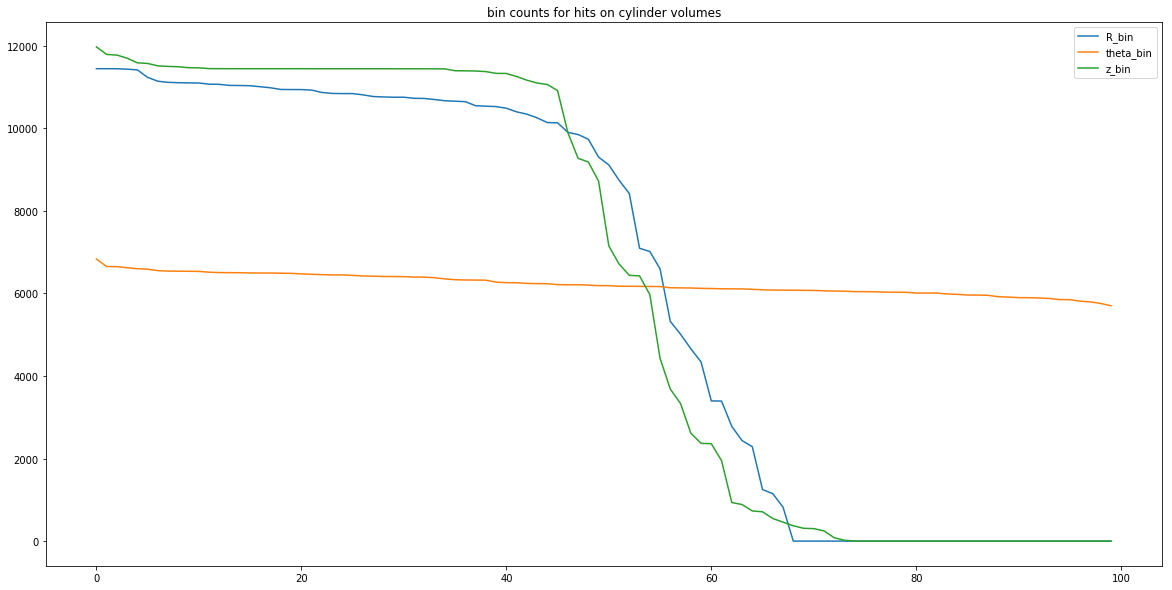

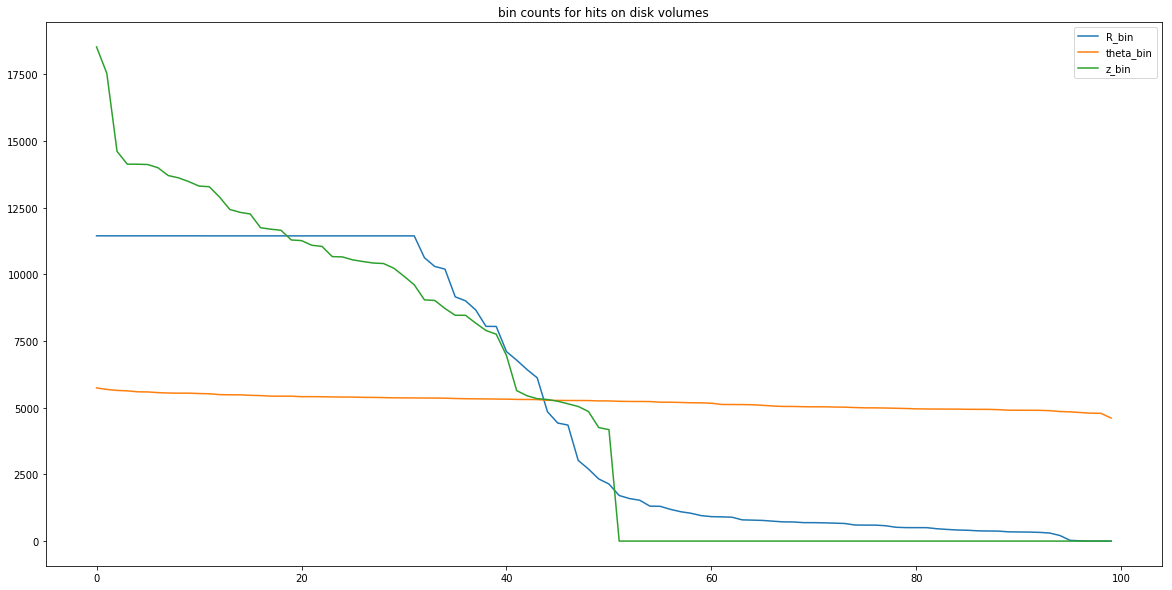

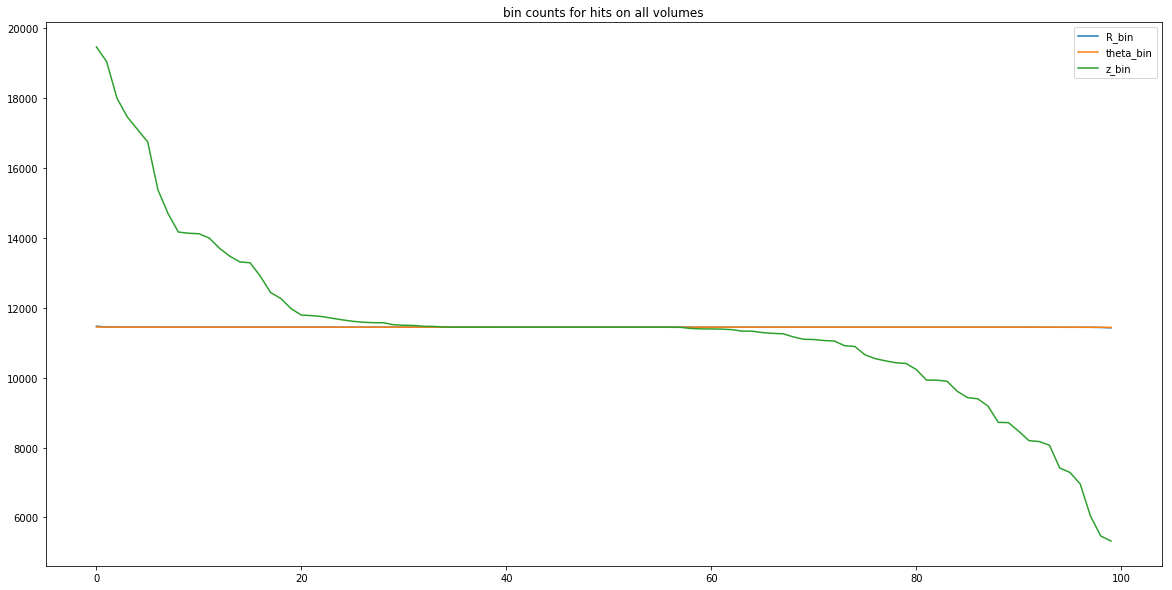

In [119]:
cylinder_bin_counts = pd.concat(
    [
        cylinder_hits.R_bin.value_counts().reset_index(),
        cylinder_hits.theta_bin.value_counts().reset_index(),
        cylinder_hits.z_bin.value_counts().reset_index(),
    ],
    axis=1
)
cylinder_bin_counts.plot(figsize=(20, 10))
plt.title('bin counts for hits on cylinder volumes')
plt.show()

disk_bin_counts = pd.concat(
    [
        disk_hits.R_bin.value_counts().reset_index(),
        disk_hits.theta_bin.value_counts().reset_index(),
        disk_hits.z_bin.value_counts().reset_index(),
    ],
    axis=1
)
disk_bin_counts.plot(figsize=(20, 10))
plt.title('bin counts for hits on disk volumes')
plt.show()

all_bin_counts = pd.concat(
    [
        hits.R_bin.value_counts().reset_index(),
        hits.theta_bin.value_counts().reset_index(),
        hits.z_bin.value_counts().reset_index(),
    ],
    axis=1
)
all_bin_counts.plot(figsize=(20, 10))
plt.title('bin counts for hits on all volumes')
plt.show()

In [141]:
def bin_counts(hits_df, event_id=None):
    if event_id is not None:
        hits_df = hits_df[hits_df.event_id == event_id]
    
    return hits_df.groupby(['R_bin', 'theta_bin', 'z_bin']).size().value_counts()

def show_bin_counts(hits_df, event_id=None):
    bc = bin_counts(hits_df, event_id)
    print("number of bins occupied:", bc.sum(), '\n')
    print("(hit count, number of bins having hit count)\n")
    print(bc)

# hits[hits.event_id == 21000].groupby(['R_bin', 'theta_bin', 'z_bin']).size().value_counts()
show_bin_counts(hits)

number of bins occupied: 322836 

(hit count, number of bins having hit count)

1     94273
2     61585
3     44852
4     33599
5     25238
6     18983
7     13378
8      9249
9      6571
10     4566
11     3170
12     2036
13     1420
14     1073
15      696
16      488
17      391
18      265
19      201
20      150
22      119
21      114
23       78
24       58
25       57
27       42
29       37
26       36
28       30
30       18
33       16
31       15
32       11
36        5
34        5
39        4
35        4
37        2
40        1
dtype: int64


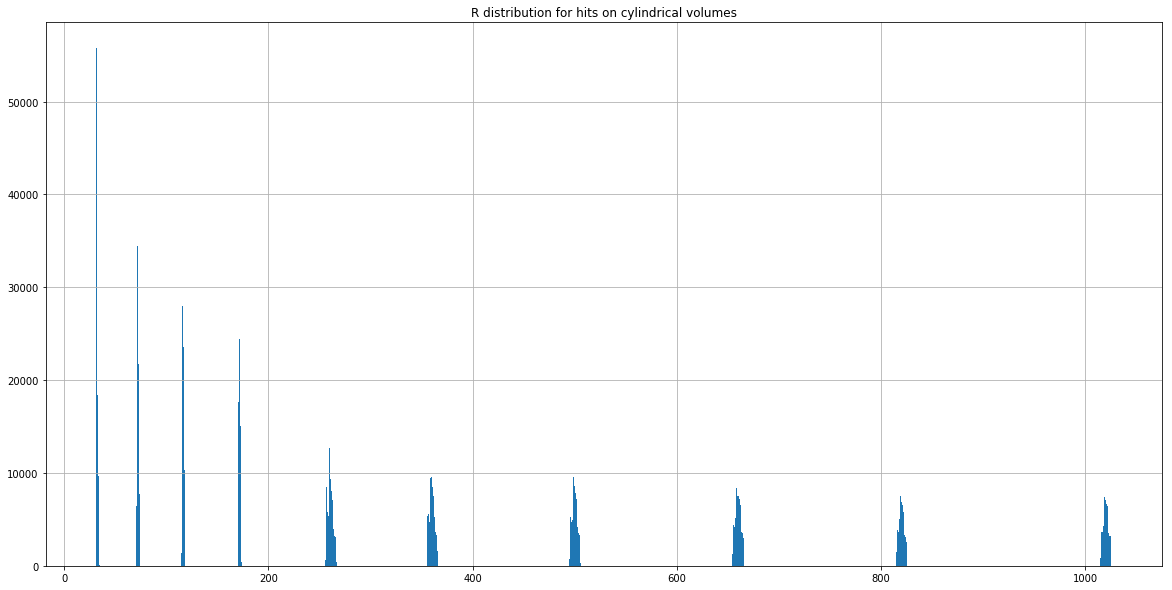

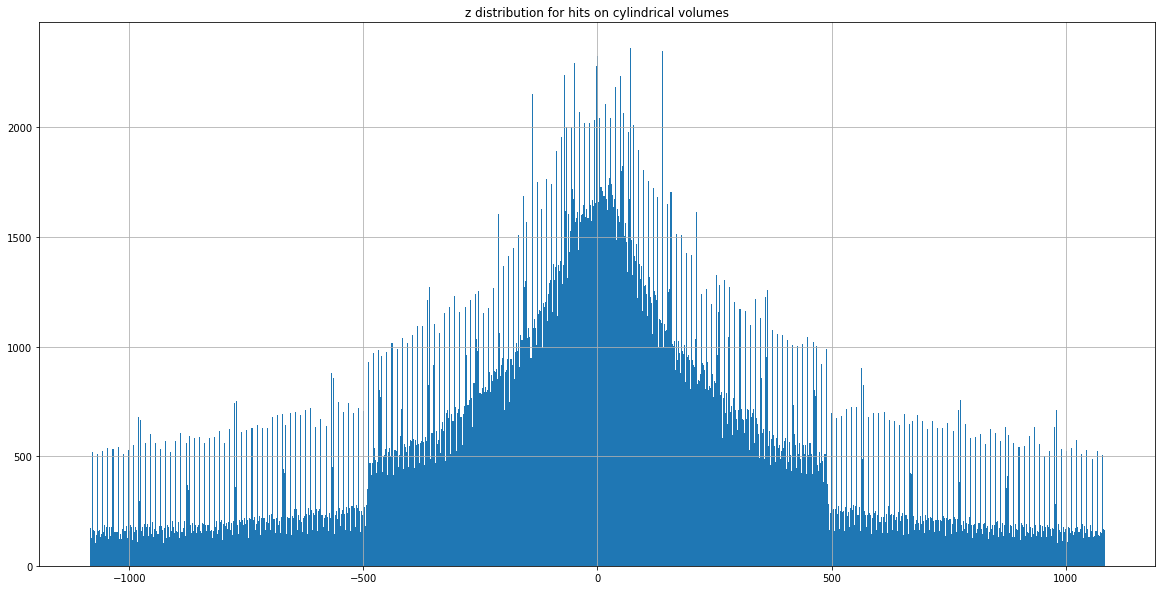

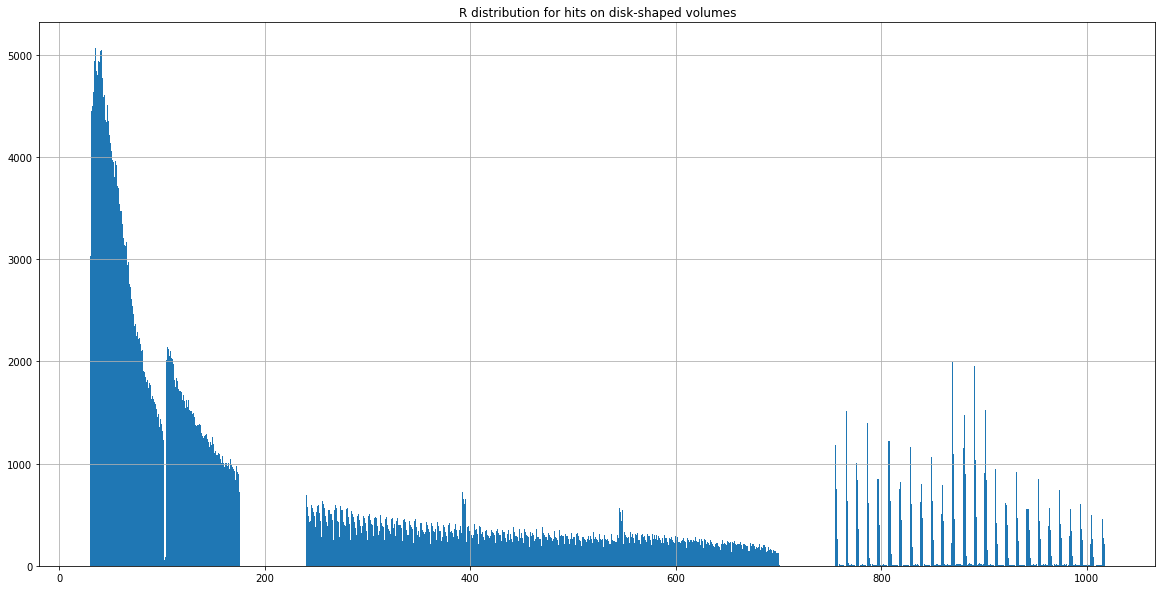

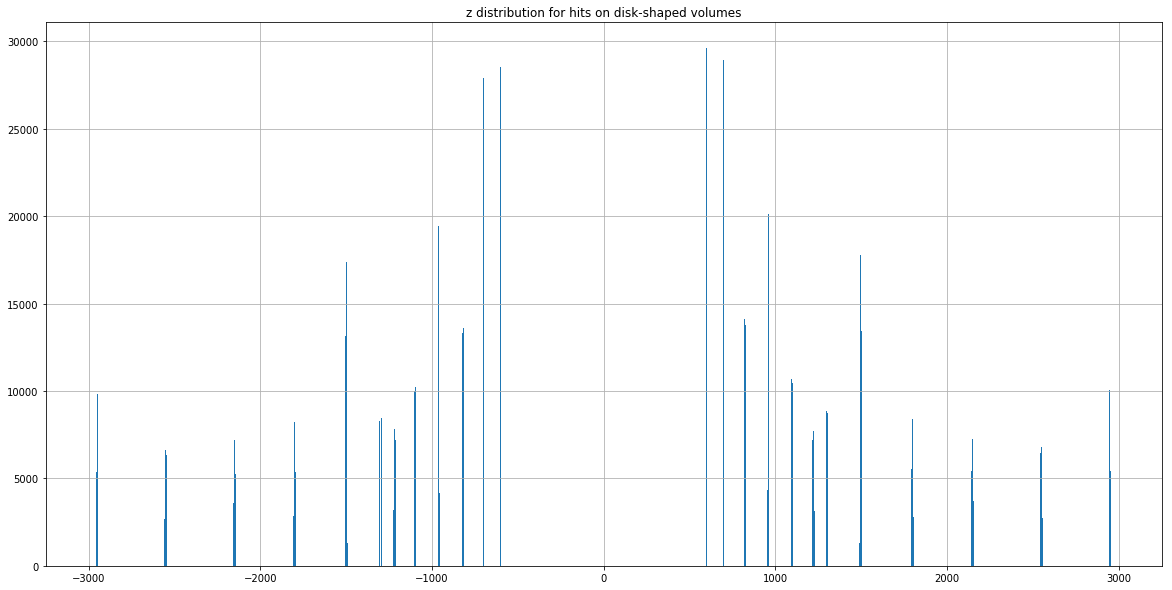

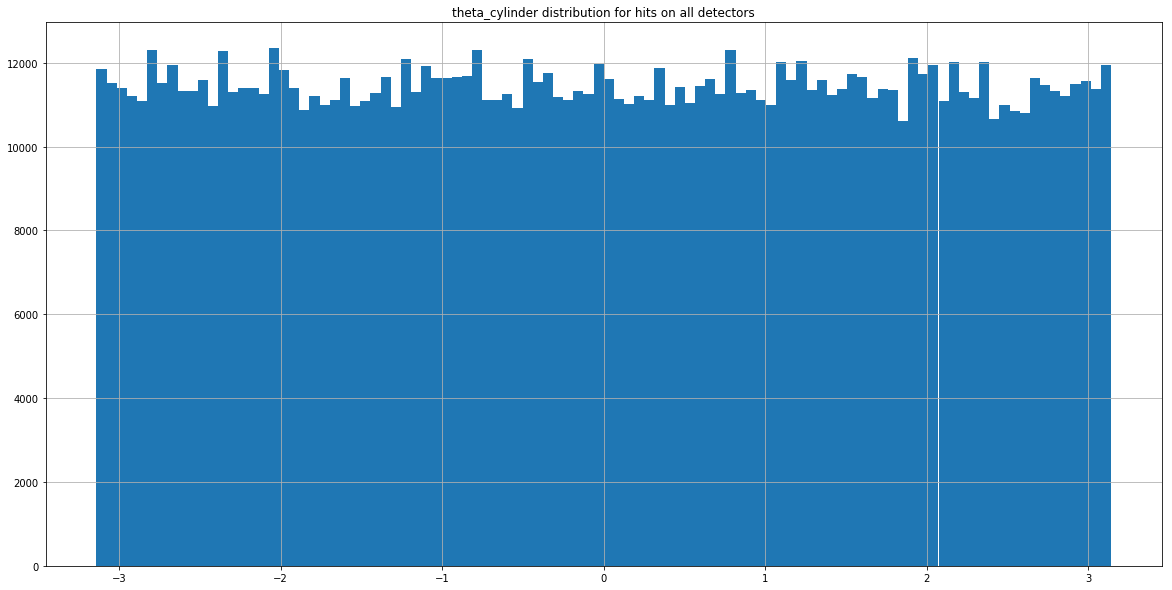

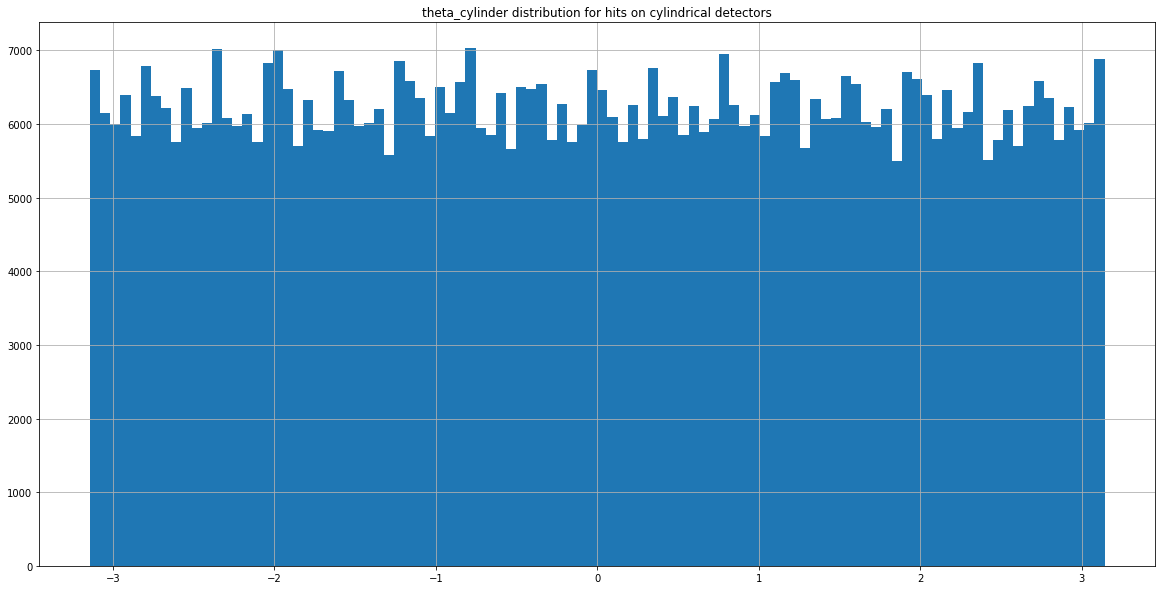

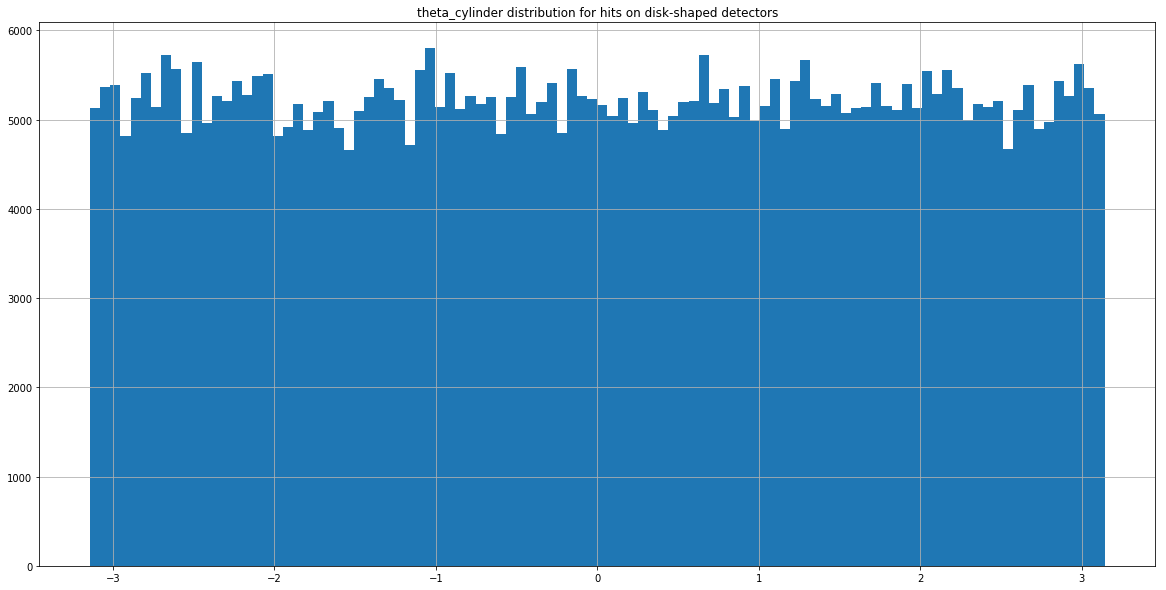

In [85]:
cylinder_hits.R.hist(bins=1000, figsize=(20, 10))
plt.title("R distribution for hits on cylindrical volumes")
plt.show()

cylinder_hits.z.hist(bins=1000, figsize=(20, 10))
plt.title("z distribution for hits on cylindrical volumes")
plt.show()

disk_hits.R.hist(bins=1000, figsize=(20, 10))
plt.title("R distribution for hits on disk-shaped volumes")
plt.show()

disk_hits.z.hist(bins=1000, figsize=(20, 10))
plt.title("z distribution for hits on disk-shaped volumes")
plt.show()

hits.theta.hist(bins=100, figsize=(20, 10))
plt.title("theta_cylinder distribution for hits on all detectors")
plt.show()

cylinder_hits.theta.hist(bins=100, figsize=(20, 10))
plt.title("theta_cylinder distribution for hits on cylindrical detectors")
plt.show()

disk_hits.theta.hist(bins=100, figsize=(20, 10))
plt.title("theta_cylinder distribution for hits on disk-shaped detectors")
plt.show()

p_hit_event = .1 is the desired probability of a hit occuring in a typical on-detector bin for a random event.
num_hits_event ~= 100000 is average number of hits in an event

num_on_dectector_bins = 1M = num_hits_event/p_event_hit is the number of on-detector bins needed to produce average hit probability p_hit.

num_cylinder_bins = number of bins on the surface of cylindrical detectors
num_disk_bins = number of bins on the surface of disk detectors

R_bins
theta_bins
z_bins

R_bins is constructed using disk_hits
z_bins is constructed using cylinder_hits
theta_bins is constructed using all hits

num_disk_bins ~= len(R_bins)\*len(theta_bins)
num_cylinder_bins ~= len(z_bins)\*len(theta_bins)

num_on_detector_bins ~= num_disk_bins\*num_cylinder_bins

Initial guess will be len(R_bins) = len(theta_bins) = len(z_bins) = sqrt(num_on_detector_bins/2)

***

p_hit = p_hit_event/num_hits_event = ~1/num_on_detector_bins ~= 1E-6 is probability that a randomly chosen hit will occur in a typical bin. Second approximate equality holds when p_hit_event is small

p_hit_cylinder ~= z_q\*theta_q
p_hit_disk ~= R_q\*theta_q

p_hit ~= mean(R_q\*theta_q, z_q\*theta_q)


Initially choose R_q = theta_q = sqrt(p_hit) = 1E-3

In [69]:
disk_hits.z.value_counts()

 598.0     9306
 602.0     9223
 698.0     9161
-598.0     9044
 702.0     9023
-602.0     8914
 818.0     8907
-698.0     8777
-702.0     8764
 822.0     8720
-818.0     8609
-822.0     8466
 958.0     7976
 962.0     7896
-958.0     7757
-962.0     7608
 1098.0    7171
 1102.0    6957
-1098.0    6846
-1102.0    6663
 1298.0    6218
 1302.0    6046
-1298.0    5911
-1302.0    5816
 597.5     5641
 1498.0    5464
 697.5     5450
 602.5     5450
-597.5     5338
 1502.0    5320
           ... 
-2544.5    1213
-2944.5    1206
-1794.5    1205
 1794.5    1200
 2944.5    1195
-2144.5    1183
-1797.5    1176
-1222.5    1174
 1222.5    1164
 2947.5    1162
-1225.5    1156
 1225.5    1110
-1505.5    1048
 1505.5     996
 2952.5     982
 2552.5     976
-2955.5     970
 2955.5     963
-2552.5     962
 2555.5     953
-2952.5     945
-2555.5     936
-2152.5     922
 2152.5     922
 1802.5     920
 2155.5     919
-2155.5     908
 1805.5     895
-1805.5     874
-1802.5     813
Name: z, Length: 148, dt